In [1]:
import numpy as np
import numpy.random as npr
import matplotlib.pyplot as plt
import ssm
from ssm.util import find_permutation
from pathlib import Path
from scipy import io

npr.seed(0)
rng = npr.default_rng()

rnn_dirs = sorted(Path("rnns/").iterdir())
import pandas as pd

N_iters = 300

In [2]:
def load_rnn(rnn_dirs, rnn_num):
    trial = io.loadmat(rnn_dirs[rnn_num * 2 - 1])
    return trial['test_out']

In [3]:
model_choices = [(load_rnn(rnn_dirs, rnn_num)[:,:,-50:].mean(axis=2) > 0.5).astype(int).reshape(-1,1) for rnn_num in range(1,6)]
model_choices = np.array(model_choices)
model_choices.shape

(5, 200, 1)

In [4]:
def make_covariates(n_sessions = 5, n_trials = 200):

    bias = np.zeros((n_sessions, n_trials, 1))

    first_stimulus = np.array([[x]*50 for x in [1,1,0,0]] * n_sessions).reshape(n_sessions,-1,1)
    second_stimulus = np.array([[x]*50 for x in [0,0,1,1]] * n_sessions).reshape(n_sessions,-1,1)
    covariates = np.concatenate((first_stimulus, second_stimulus, bias), axis=2)
    return covariates

In [5]:
train_choices = model_choices[:-1]
train_covs = make_covariates(n_sessions=4, n_trials=200)

shuffle_mix = np.concatenate((train_choices, train_covs), axis=2)
rng.shuffle(shuffle_mix, axis=1)

train_choices = shuffle_mix[:, :, 0:1].astype(int)
train_covs = shuffle_mix[:, :, 1:].astype(int)



test_choices = model_choices[-1].reshape(1,-1,1)
test_covs = make_covariates(n_sessions=1, n_trials=200)

shuffle_mix = np.concatenate((test_choices, test_covs), axis=2)
rng.shuffle(shuffle_mix, axis=1)

test_choices = shuffle_mix[:, :, 0:1].astype(int)
test_covs = shuffle_mix[:, :, 1:].astype(int)


train_choices.shape, train_covs.shape, test_choices.shape, test_covs.shape

((4, 200, 1), (4, 200, 3), (1, 200, 1), (1, 200, 3))

In [6]:
def train_hmm_mle(num_states, model_choices, covariates):

    # Set the parameters of the GLM-HMM
    num_states = num_states        # number of discrete states - state guess
    obs_dim = 1           # number of observed dimensions (model choices output - single value) n_final layer output dimentions
    num_categories = 2    # number of categories for output (binary model choice)
    input_dim = 3         # input dimensions (first_stimulus, second_stimulus, bias)

    # Make a GLM-HMM
    mle_glmhmm = ssm.HMM(num_states, obs_dim, input_dim, observations="input_driven_obs",
                    observation_kwargs=dict(C=num_categories), transitions="standard")

    
    ### CHECK THIS: BOTH CHOICES AND COVARIATES NEED TO LISTS OF NDARRAYS
    # _ = mle_glmhmm.fit([x for x in model_choices], inputs=[x for x in covariates], method="em", num_iters=N_iters, tolerance = 1**-4)
    _ = mle_glmhmm.fit([x for x in model_choices], inputs=[x for x in covariates], method="em", num_iters=N_iters)

    return mle_glmhmm

In [7]:
def train_hmm_map(num_states, model_choices, covariates):
    num_states = num_states
    obs_dim = 1
    num_categories = 2
    input_dim = 3

    # Instantiate GLM-HMM and set prior hyperparameters
    prior_sigma = 2
    prior_alpha = 2
    map_glmhmm = ssm.HMM(num_states, obs_dim, input_dim, observations="input_driven_obs", 
                observation_kwargs=dict(C=num_categories,prior_sigma=prior_sigma),
                transitions="sticky", transition_kwargs=dict(alpha=prior_alpha,kappa=0))
    # Fit GLM-HMM with MAP estimation:

    # _ = map_glmhmm.fit([x for x in model_choices], inputs=[x for x in covariates], method="em", num_iters=N_iters, tolerance=1**-4)
    _ = map_glmhmm.fit([x for x in model_choices], inputs=[x for x in covariates], method="em", num_iters=N_iters)
    
    return map_glmhmm

In [8]:
mle_hmms = []
map_hmms = []

for num_states in range(5):
    mle_hmms.append(train_hmm_mle(num_states+1, train_choices, train_covs))
    map_hmms.append(train_hmm_map(num_states+1, train_choices, train_covs))

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

  0%|          | 0/300 [00:00<?, ?it/s]

In [9]:
ll_mle = []
ll_map = []

for model_idx in range(5):
    ll_mle.append(mle_hmms[model_idx].log_likelihood([x for x in test_choices], inputs=[x for x in test_covs]))
    ll_map.append(map_hmms[model_idx].log_likelihood([x for x in test_choices], inputs=[x for x in test_covs]))

In [10]:
df = pd.DataFrame({'mle':ll_mle, 'map':ll_map}, index=range(1,6))
df

,mle,map
1,-136.804878,-136.807119
2,-138.554542,-138.724422
3,-138.678400,-142.840928
4,-139.244484,-141.217298
5,-140.247311,-141.052706


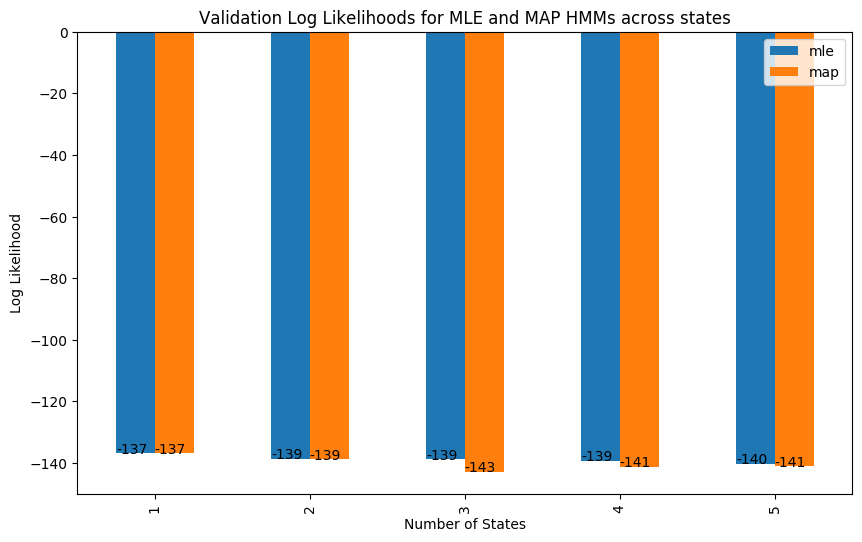

In [11]:
ax = df.plot.bar(title='Validation Log Likelihoods for MLE and MAP HMMs across states', figsize=(10,6))
ax.set_xlabel('Number of States')
ax.set_ylabel('Log Likelihood')
for p in ax.patches:
    ax.annotate(f"{float(p.get_height()):0.0f}", (p.get_x() * 1.00, p.get_height() * 1.00))

In [12]:
def plot_recovery(num_states, glmhmm, suptitle, input_dim = 3):

    mle_weights = glmhmm.observations.params
    mle_log_trans_mat = glmhmm.transitions.params

    # Plot MLE parameters:
    fig = plt.figure(figsize=(8, 3), dpi=80, facecolor='w', edgecolor='k')
    plt.subplot(1, 2, 1)
    cols = ['#ff7f00', '#4daf4a', '#377eb8', '#e41a1c', '#984ea3']
    for k in range(num_states):
        plt.plot(range(input_dim), mle_weights[k][0], marker='o',
                color=cols[k], linestyle='-',
                lw=1.5, label="state " + str(k+1))
    plt.yticks(fontsize=10)
    plt.ylabel("GLM weight", fontsize=15)
    plt.xlabel("covariate", fontsize=15)
    plt.xticks([0, 1, 2], ['first_stimulus', 'second_stimulus', 'bias'], fontsize=10, rotation=45)
    plt.axhline(y=0, color="k", alpha=0.5, ls="--")
    plt.legend()
    plt.title("Recovered weights", fontsize = 15)

    plt.subplot(1, 2, 2)
    gen_trans_mat = np.exp(mle_log_trans_mat)[0]
    plt.imshow(gen_trans_mat, vmin=-0.8, vmax=1, cmap='bone')
    for i in range(gen_trans_mat.shape[0]):
        for j in range(gen_trans_mat.shape[1]):
            text = plt.text(j, i, str(np.around(gen_trans_mat[i, j], decimals=2)), ha="center", va="center",
                            color="k", fontsize=12)
    plt.xlim(-0.5, num_states - 0.5)
    plt.xticks(range(0, num_states), (str(x) for x in range(1, num_states + 1)), fontsize=10)
    plt.yticks(range(0, num_states), (str(x) for x in range(1, num_states + 1)), fontsize=10)
    plt.ylim(num_states - 0.5, -0.5)
    plt.ylabel("state t", fontsize = 15)
    plt.xlabel("state t+1", fontsize = 15)
    plt.title("Recovered transition matrix", fontsize = 15)
    plt.suptitle(suptitle, y = 1.1, fontsize = 20)
    plt.show()

--------------------


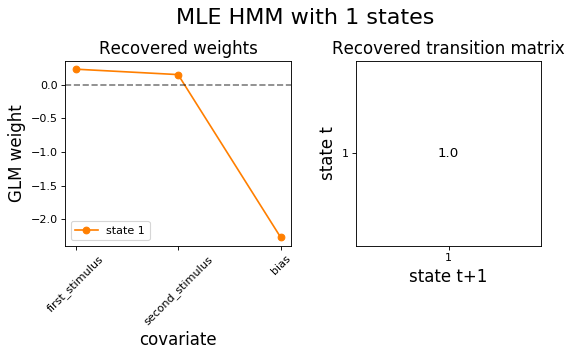

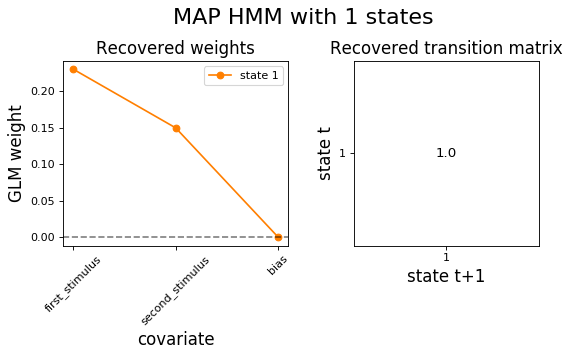

--------------------


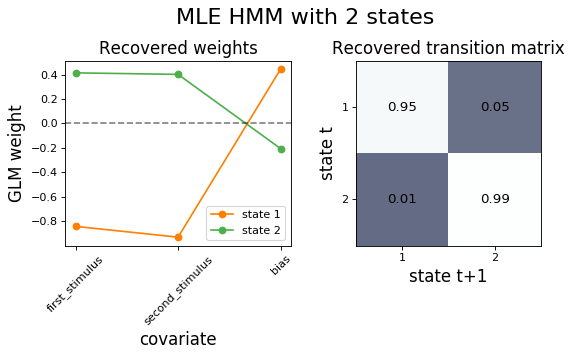

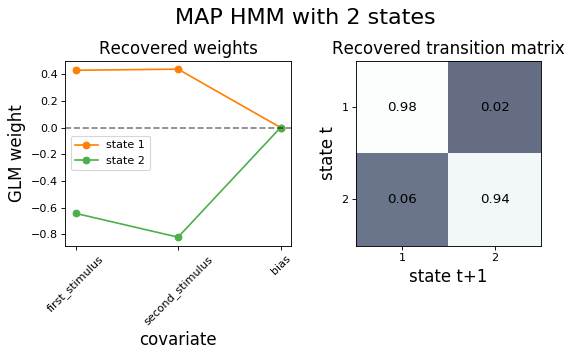

--------------------


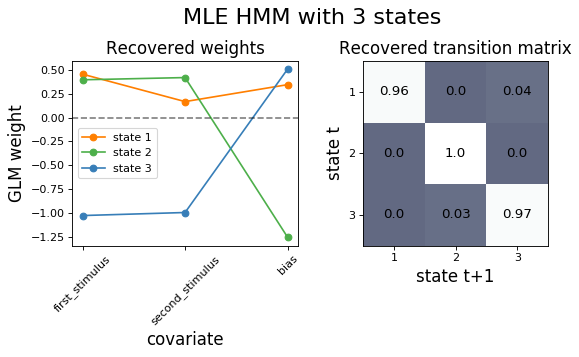

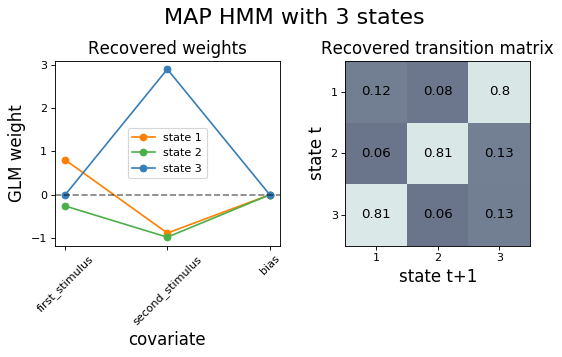

--------------------


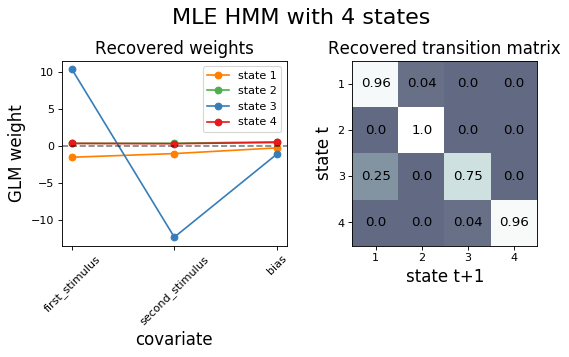

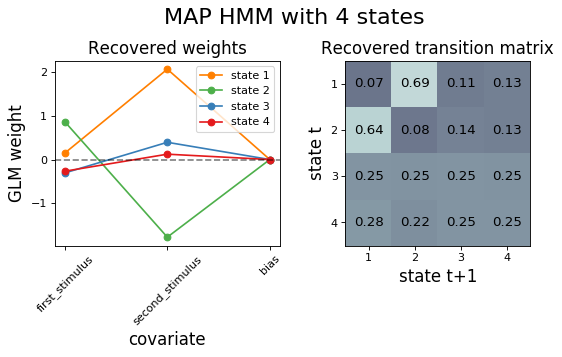

--------------------


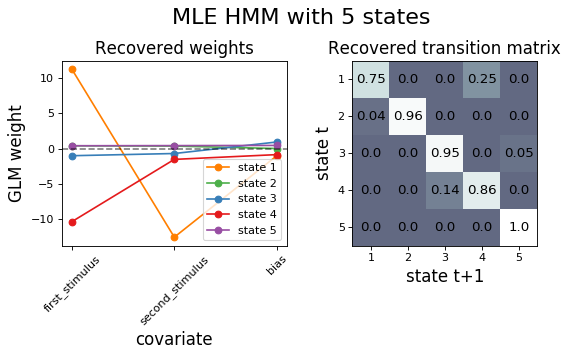

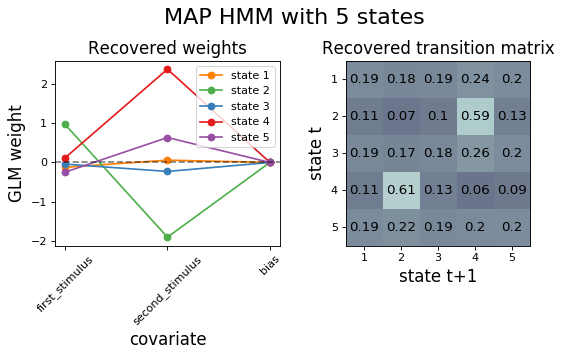

In [13]:
for idx in range(5):
    print("-"*20)
    plot_recovery(idx+1, mle_hmms[idx], f"MLE HMM with {idx+1} states")
    plot_recovery(idx+1, map_hmms[idx], f"MAP HMM with {idx+1} states")

In [14]:
def get_predictive_accuracy(hmm_model, test_choices, test_covs, class_considered = 1):
    # This function only works for binary observations
    # The idea is that we want to get the accurate probability for a specific class
    # - get the expected state probabilities for each trial
    # - multiply the expected state probabilities with the probability of the chosen (class) choice
    # - binarize and compare with actual choice to get accuracy

    expectations = [
        hmm_model.expected_states(data=data,
                                input=input)[0]
        for data, input in zip(test_choices, test_covs)
    ]

    # Flatten all trials across sessions into one long array
    posterior_probs = np.concatenate(expectations, axis=0)

    prob_right = [
        np.exp(hmm_model.observations.calculate_logits(input=input))
        for data, input,  in zip(test_choices, test_covs)
    ]
    # Flatten all trials across sessions into one long array
    prob_right = np.concatenate(prob_right, axis=0)

    # Seclect which class to calcualte the probability for: (here selected second class -> 1 positive)
    prob_right = prob_right[:, :, class_considered]

    # Now multiply posterior probs and prob_right and sum over latent axis:
    final_prob_right = np.sum(np.multiply(posterior_probs, prob_right), axis=1)

    # Get the predicted label for each time step:
    predicted_label = np.around(final_prob_right, decimals=0).astype('int')

    # See if the predicted label matches the actual label:
    predictive_acc = np.sum(test_choices.flatten() == predicted_label) / len(predicted_label)

    return predictive_acc

In [15]:
acc_mle = []
acc_map = []

for model_idx in range(5):
    acc_mle.append(get_predictive_accuracy(mle_hmms[model_idx], test_choices, test_covs))
    acc_map.append(get_predictive_accuracy(map_hmms[model_idx], test_choices, test_covs))

In [16]:
acc_df = pd.DataFrame({'mle':acc_mle, 'map':acc_map}, index=range(1,6))
acc_df

,mle,map
1,0.56,0.560
2,0.56,0.580
3,0.57,0.770
4,0.59,0.770
5,0.62,0.785


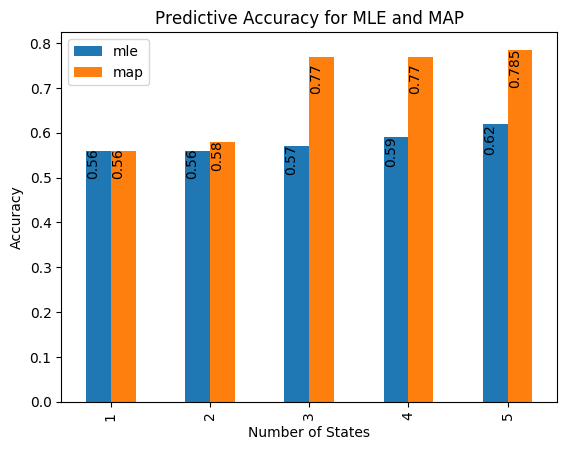

In [17]:
ax = acc_df.plot.bar(title='Predictive Accuracy for MLE and MAP')
ax.set_xlabel('Number of States')
ax.set_ylabel('Accuracy')
for p in ax.patches:
    ax.annotate(f"{float(p.get_height())}", (p.get_x() * 1.00, p.get_height() * 0.90), rotation=90)